<img src="images/econ140R_logo.png" width="200" />

<h1>ECON 140R Class 19</h1>

<b>Serial correlation</b> is another big problem in time series econometrics, and it can also be a problem in difference-in-differences (DID) models of <i>panel data</i> in Chapter 5 of <i>Mastering Metrics</i>. "Time series data" means you have observations chiefly over time. "Panel data" includes observations over time of multiple units, like people, states, or countries. 

The off-the-shelf solutions are different for time series vs. for panel data. Today we will wrap up time series, and next time we will take up panel data with Chapter 5 and difference-in-differences estimation.

Learning objectives:

0. "Serially correlated" and "autocorrelated" are synonyms
1. A standard form of serial correlation is called "autoregressive of order 1" or AR(1), where $\epsilon_t$ depends on $\epsilon_{t-1}$
2. You can test for this by running a regression, gathering the residuals $\epsilon_t$, and regressing $\epsilon_t$ on $\epsilon_{t-1}$
3. You can also use off-the-shelf routines like `cochrane-orcutt()`
4. You can also run a model with time-differenced data

Let us examine the `phillips` data (i.e., the Phillips Curve, showing inflation and unemployment rates), from the Wooldridge package. For kicks, let us also load in `haven` like usual, and we also load in `dynlm` to run time-series models. Several other additions here are `lmtest` and `orcutt` for some nifty moves in time series.

In [1]:
library(haven)
install.packages("dynlm")
install.packages('wooldridge')
library(dynlm)
library(lmtest)
#install.packages("orcutt")
#library(orcutt)

Installing package into ‘/srv/r’
(as ‘lib’ is unspecified)

Installing package into ‘/srv/r’
(as ‘lib’ is unspecified)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [2]:
install.packages("remotes")

Installing package into ‘/srv/r’
(as ‘lib’ is unspecified)



In [3]:
remotes::install_github("cran/orcutt")


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp1VQm0I/remotes5c2da5271e/cran-orcutt-33e7ab0/DESCRIPTION’ ... OK
* preparing ‘orcutt’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a ‘data/datalist’ file should be added
* building ‘orcutt_2.3.tar.gz’



Installing package into ‘/srv/r’
(as ‘lib’ is unspecified)



In [4]:
library(orcutt)

Here are the data in the `phillips` dataset inside the Wooldridge repository. [The documentation PDF is here](https://cran.r-project.org/web/packages/wooldridge/wooldridge.pdf).

In [5]:
data(phillips, package = 'wooldridge')
head(phillips)

,year,unem,inf,inf_1,unem_1,cinf,cunem
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1948,3.8,8.1,NA,NA,NA,NA
2,1949,5.9,-1.2,8.1,3.8,-9.3,2.1000001
3,1950,5.3,1.3,-1.2,5.9,2.5,-0.5999999
4,1951,3.3,7.9,1.3,5.3,6.6,-2.0000002
5,1952,3.0,1.9,7.9,3.3,-6.0,-0.3000000
6,1953,2.9,0.8,1.9,3.0,-1.1,-0.0999999


As you can see from the call to `head()`, the dataset includes the U.S. annual inflation rate and the U.S. annual average unemployment rate. Both are in percentage points. The "first lags" of the inflation rate and unemployment rate are also present, as `inf_1` and `unem_1`. The annual change in each of them are `cinf` and `cunem`. You could use those in a call to `lm()`, or you could call `ts()` and use the time-series tools to examine the data. Here we will do the latter.

The __R__ package `dynlm` contains some special tools for dealing with time series, and `ts()` is one of them. Florian Heiss uses this package and these data in [Section 12.1](http://www.urfie.net/read/index.html#page/216).

In [6]:
tsdata <- ts(phillips, start = 1948, end = 2003)
head(tsdata)

year,unem,inf,inf_1,unem_1,cinf,cunem
1948,3.8,8.1,NA,NA,NA,NA
1949,5.9,-1.2,8.1,3.8,-9.3,2.1000001
1950,5.3,1.3,-1.2,5.9,2.5,-0.5999999
1951,3.3,7.9,1.3,5.3,6.6,-2.0000002
1952,3.0,1.9,7.9,3.3,-6.0,-0.3000000
1953,2.9,0.8,1.9,3.0,-1.1,-0.0999999


<h2>Visualization</h2>

It is always a good idea to look at the data, to put it mildly. Here is a call to the simple `plot()` routine, which is how I roll. Power users will do some cool `ggplot()` stuff instead. Go for it!

The original idea with the Phillips curve as discussed by [A. W. Phillips (1958)](https://www-jstor-org.libproxy.berkeley.edu/stable/2550759) was that wage inflation might be a function of unemployment. Here is the killer chart with which Phillips led off that paper:

<img src="images/phillips-fig1.png" width="500" />

And here is what the same graph looks like with in our dataset, which covers U.S. data on consumer price inflation and unemployment from 1948-2003:

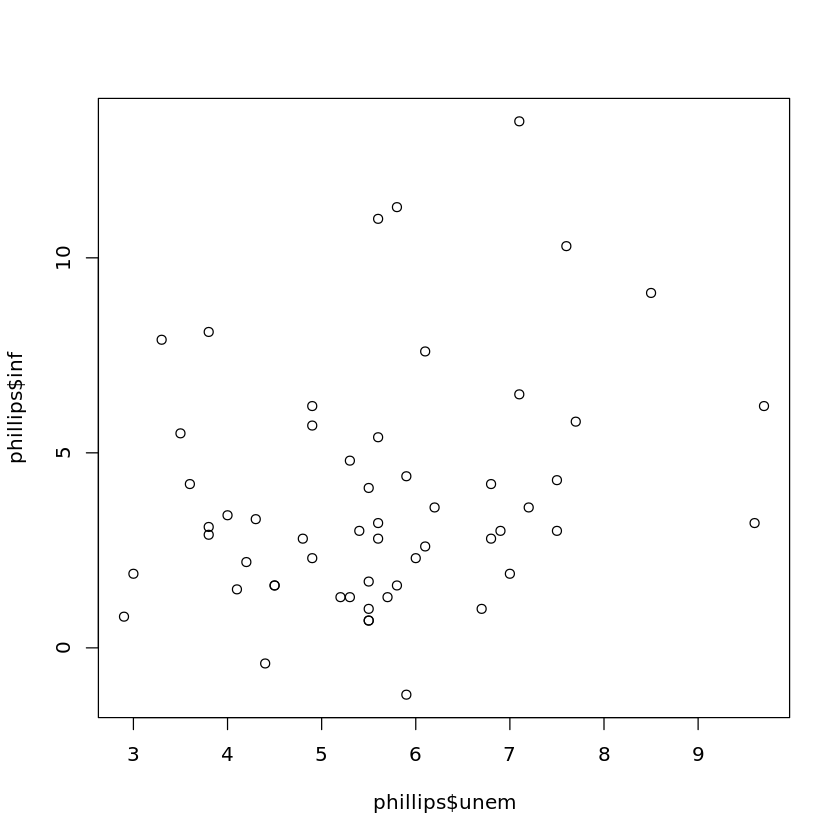

In [7]:
plot(phillips$unem, phillips$inf)

With a picture like this, we are in for some chop, as they say! Still, let us proceed. In levels of the variables, as are depicted above, the Phillips Curve relationship is:

$$
\pi_t = \alpha + \beta \ u_t + \epsilon_t
$$

where $\pi_t$ is the inflation rate and $u_t$ is the unemployment rate.

<h2>OLS results</h2>

Our first approach is simple OLS, here using `dynlm()` for no particular reason. We could also use `lm()` and get the same results.

In [8]:
reg_pc_levels <- dynlm(inf ~ unem, data = tsdata)
summary(reg_pc_levels)


Time series regression with "ts" data:
Start = 1948, End = 2003

Call:
dynlm(formula = inf ~ unem, data = tsdata)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.2176 -1.7812 -0.6659  1.1473  8.8795 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   1.0536     1.5480   0.681   0.4990  
unem          0.5024     0.2656   1.892   0.0639 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.972 on 54 degrees of freedom
Multiple R-squared:  0.06215,	Adjusted R-squared:  0.04479 
F-statistic: 3.579 on 1 and 54 DF,  p-value: 0.06389


Unlike in Phillips's original dataset, here we find a <i>positive relationship</i> between inflation and unemployment. This would be remarkably good news for governments and central banks if it were true; economies could have their cake (low unemployment) and eat it too (low inflation). But is it true? Or is our model misspecified? (Spoiler alert: yes.)

Like we did in Class 17, let us plot the residuals.

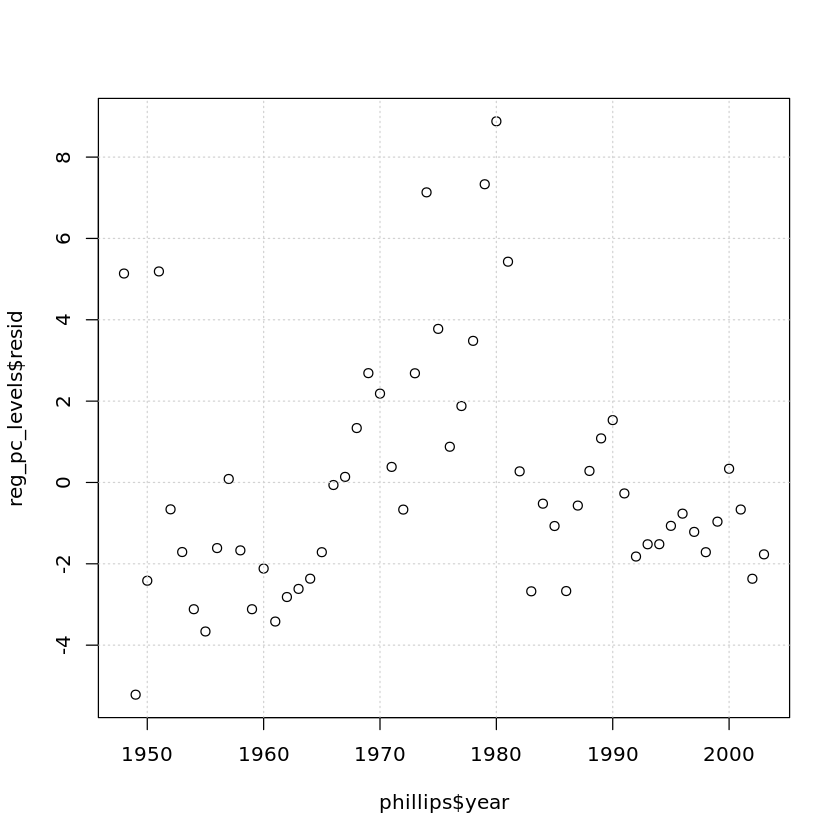

In [9]:
plot(phillips$year, reg_pc_levels$resid)
grid()

Yikes! Zoinks! Those are <i>seriously</i> serially correlated residuals. What can we do?!

<h2>Durbin-Watson statistic</h2>

Before we go further, allow me to introduce the [Durbin-Watson statistic](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic), here calculated by calling `dwtest()` on the OLS regression that we just ran. The DW statistic is a standard diagnostic measure in time series analysis. If the DW stat is near the number 2, there is little evidence of serially correlated errors. In large samples, the DW stat trends toward $d = 2(1 - \rho)$ where $\rho$ is the first-order autocorrelation in the residuals:

$$
\epsilon_t = \rho \ \epsilon_{t-1} + \nu_t
$$

Thus if there is positive serial correlation, $\rho \in (0,1)$, and the DW stat is less than 2. If there is negative serial correlation, $\rho \in (-1,0)$, and the statistic is greater than 2. (We cannot have $| \rho | > 1$, because if that were the case, the errors would grow forever.)

<h4>What level of the DW statistic is reasonable?</h4> I am not certain whether there are hard-and-fast rules. The range of 1.5 - 2.5 appears to be the standard "acceptable range" in the literature and on various websites.

In [10]:
dwtest(reg_pc_levels)


	Durbin-Watson test

data:  reg_pc_levels
DW = 0.80148, p-value = 1.486e-07
alternative hypothesis: true autocorrelation is greater than 0


We have positive serial correlation in the OLS model. One approach would be to run the iterative [Cochrane-Orcutt procedure](https://en.wikipedia.org/wiki/Cochrane%E2%80%93Orcutt_estimation), often called "corc" and pronounced "cork" for short. The corc procedure assumes that autocorrelation is first-order only, meaning there are no further lagged effects, and the algorithm produces decent results off the shelf. Here is how to use it in __R__:

In [11]:
reg_pc_levels_corc <- cochrane.orcutt(reg_pc_levels)
reg_pc_levels_corc
summary(reg_pc_levels_corc)

Cochrane-orcutt estimation for first order autocorrelation 
 
Call:
dynlm(formula = inf ~ unem, data = tsdata)

 number of interaction: 12
 rho 0.782009

Durbin-Watson statistic 
(original):    0.80148 , p-value: 1.486e-07
(transformed): 1.60020 , p-value: 6.435e-02
 
 coefficients: 
(Intercept)        unem 
   7.287079   -0.663959 

Call:
dynlm(formula = inf ~ unem, data = tsdata)

            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  7.28708    2.16318   3.369 0.001414 **
unem        -0.66396    0.29420  -2.257 0.028168 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.1428 on 53 degrees of freedom
Multiple R-squared:  0.0877 ,  Adjusted R-squared:  0.0705
F-statistic: 5.1 on 1 and 53 DF,  p-value: < 2.817e-02

Durbin-Watson statistic 
(original):    0.80148 , p-value: 1.486e-07
(transformed): 1.60020 , p-value: 6.435e-02

Describe what you see here compared to the OLS results above. What is $\rho$ in the autocorrelated errors? Is it zero? What has happened to $\beta$, the effect of unemployment on inflation?

<hr>

The <b>residuals</b> created by the corc procedure are a little funny. I'm pretty sure the routine's `resid` output are the uncorrected OLS-style error terms. Observe the insanity:

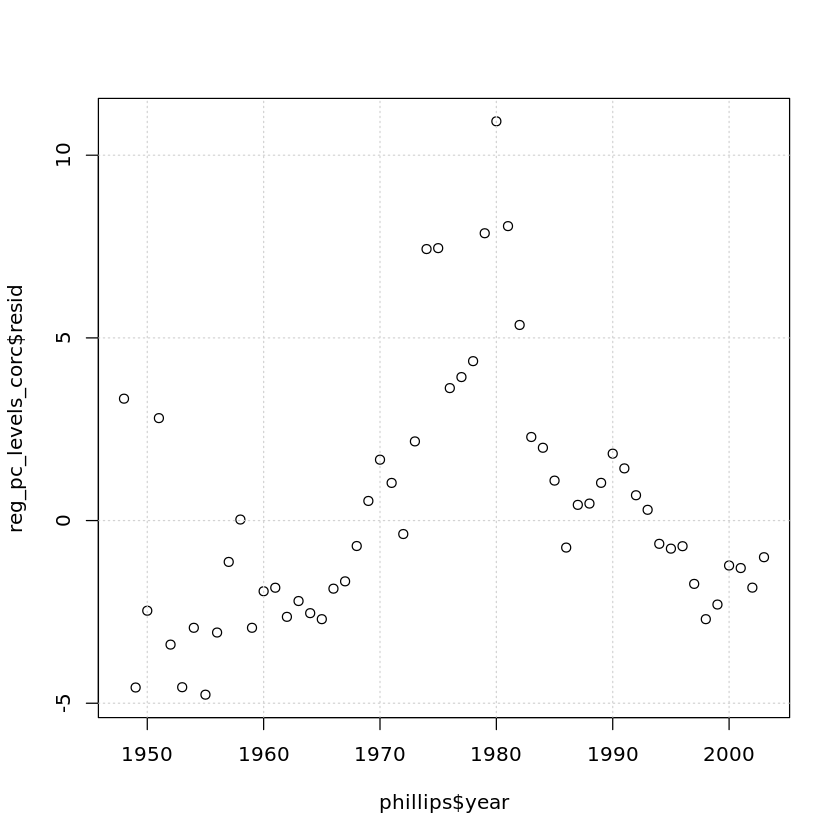

In [18]:
plot(phillips$year, reg_pc_levels_corc$resid)
grid()

Yuck. But if we manually apply the estimate of $\rho$, the first-order autocorrelation in the error term, we get something that looks better:

In [19]:
reg_pc_levels_corc$rho

[1] 0.7820094

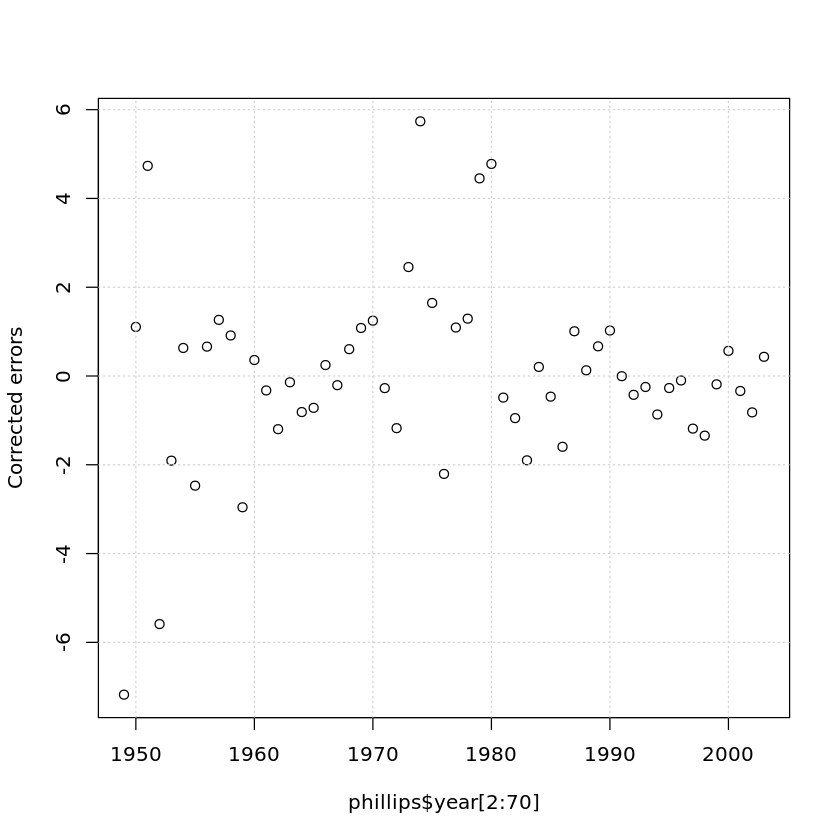

In [26]:
plot(phillips$year[2:70], 
 reg_pc_levels_corc$resid[2:70] - 
 reg_pc_levels_corc$rho * reg_pc_levels_corc$resid[1:69], 
 ylab = "Corrected errors")
grid()

Another thing we can do is <i>difference</i> the data. This is very quick and easy in data filtered through `ts()`, like we did above; we just call `d()`, which returns the time difference. The code below estimates this model:

$$
\Delta \pi_t = \alpha^d + \beta^d \ u_t + \epsilon^d_t
$$

where $\Delta \pi_t \equiv \pi_t - \pi_{t-1}$. Note that because we are not differencing `unem`, the parameters here have no particular relationship to the $\alpha$ and $\beta$ we wrote down above, because the two regression equations are not just differenced versions of each other.

In [ ]:
reg_pc_diff <- dynlm(d(inf) ~ unem, data = tsdata)
summary(reg_pc_diff)

Let us also calculate the DW stat for this regression of differenced inflation on unemployment.

In [ ]:
dwtest(reg_pc_diff)

And let us plot the residuals from the regression of differenced inflation:

In [ ]:
plot(phillips$year[2:56], reg_pc_diff$resid)
grid()

Describe what you see. Are the errors well behaved, or are we seeing evidence of serial correlation? What is $\beta^d$ in the regression of $\Delta \pi_t$ on $u_t$? How does it compare to $\beta$ in the first OLS model we ran?

We can also examine a scatterplot of the model itself, which is probably easiest to do with the hard-coded variable `cinf`, the change in inflation. 

In [ ]:
plot(phillips$unem, phillips$cinf)

This is definitely "more like it" in the sense of our seeing a negative relationship between something having to do with inflation and something having to do with unemployment. But even though the time-series econometrics of this model are better, meaning that it is probably useful for forecasting, I do not think the economics of it are particularly great. 

We could improve the economics of the model by looking in an intermediate macroeconomics textbook. There we might find something that looks like this:

$$
\Delta \pi_t = \beta (u_t - \bar{u}) + \epsilon_t
$$

where $\bar{u}$ is the trend or non-accelerating inflation rate of unemployment (NAIRU), which might be shifting around or a number like 5.0 percent. Alternatively, one could compare something like real GDP and potential GDP. These types of things would help make this time-series model better in an economic sense.

<hr>

<h1>Ray Fair's election model</h1>

[Ray Fair](https://economics.yale.edu/people/ray-fair) is John M. Musser Professor of Economics and Professor of Management at Yale. Fair has done a ton of superb macroeconometrics. One of my favorites is his [model of U.S. Presidential elections](https://fairmodel.econ.yale.edu/vote2020/indexne2.htm). He also just updated (Oct 27, 2022) his [forecasts for the 2022 House elections](https://fairmodel.econ.yale.edu/vote2020/indexne1.htm), in which his model predicts the Democrats will win 46.62 percent of the national vote. Fair's model does not perform state-by-state or district-by-district forecasts, but the prediction implies $0.4662 \times 435 = 203$ House seats held by Democrats in the 118th Congress, 232 by Republicans.

For reference, you can consult [Fair (2009) on JSTOR](https://www-jstor-org.libproxy.berkeley.edu/stable/25193867). 

The setup of the data and the model are fairly complex. In U.S. data, it is reasonable to model the <b>outcome</b> as the vote share for the Democratic Party, a number like 51.0 for a national win by 1 percentage point. Fair could have modeled the Republican share instead; there is no particular reason to choose one or the other, but one would have to recode the dataset if one made that switch.

In the dataset, the outcome variable is `vp`, the share of the Presidential vote won by the Democrat.

The right-hand-side variables include these political "signed" variables:

* `i`, which equals $1$ if the incumbent/outgoing President is a Democrat, and $-1$ if Republican
* `dper`, which equals $1$ if the incumbent President is a Democrat running again,  $-1$ if Republican, and $0$ if the incumbent is not running
* `dur`, which equals $0$ if the party has held the Presidency for only 1 term, $1$ if the Democrats have held the Presidency for 2 terms, and $-1$ if the Republicans have held it for 2 terms
* `war`, which an indicator variable for any world wars during the preceding 4 years

And the other right-hand-side variables are economic indicators, which are "moving averages" in nature:

* `g` is the growth rate of real per capita GDP in the first 3 quarters of the election year (annual rate)
* `p` is the absolute value of the growth rate of the GDP deflator (price index) in the first 15 quarters of the administration
* `z` is the number of quarters in the first 15 of the administration when GDP is greater than 3.2 percent (annual rate)

Fair multiplies the economic variables by the incumbent party variable `i` to "sign" them, and calls those variables `gi`, `pi`, and `zi`. Then the regression equation is:

$$
vp_t = \alpha + \beta^g \ gi_t + \beta^p \ pi_t + \beta^z \ zi_t 
+ \gamma^1 \ dper_t + \gamma^2 \ dur_t + \gamma^3 \ i_t + \gamma^4 \ war_t + \epsilon_t
$$

In [ ]:
fair_pres <- read_dta("data/fair_pres.dta")
fair_pres
fair_pres_ts <- ts(fair_pres, start = 1916, frequency = 0.25)

It might be useful to plot the variable of interest against time. This is the recorded Democratic share of the Presidential vote every 4 years.

In [ ]:
plot(fair_pres$t, fair_pres$vp)
grid()

Now let us run Fair's Presidential election model. We can call `dynlm()` or `lm()` here, because as we will see, there appears not to be a lethal amount of serial correlation.

In [ ]:
fair_pres_reg <- dynlm(vp ~ gi + pi + zi + dper + dur + i + war, 
                       data = fair_pres_ts)
summary(fair_pres_reg)

Do we see any serial correlation in the residuals? Let us run the Durbin-Watson test:

In [ ]:
dwtest(fair_pres_reg)

If we take the acceptable range for the DW stat as 1.5 to 2.5, then it appears we are just inside that safe zone.

Let us look at the residuals.

In [ ]:
plot(fair_pres$t, fair_pres_reg$resid)
grid()

It might also be interesting to look at the predicted values. These are what the model claims should happen in the Presidential election in terms of the Democratic vote share, based on data on Presidential elections since 1916.

In [ ]:
plot(fair_pres$t, fair_pres_reg$fitted.values)
grid()

In [ ]:
fair_pres_reg16 <- dynlm(vp ~ gi + pi + zi + dper + dur + i + war, 
                       data = fair_pres_ts,
                      end = 2016)
summary(fair_pres_reg16)

In [ ]:
plot(fair_pres$t[1:26], fair_pres_reg16$resid)
grid()

<div style="text-align: right"> <span style="font-family:Papyrus; ">And they lived happily ever after. The End.</span></div>